# Introduction

This jupyter notebook illustrates a template workflow for creating and analyzing PIV data of migrating cells in a scratch wound assay. This approach was used in:

$\alpha$-catenin middle- and actin-binding domain unfolding mutants differentially impact epithelial strength and sheet migration<br>
Quinn JM, Wood M, Wang Y, Flozak AS, Le PM, Yemelyanov A, Oakes PW, and Gottardi CJ<br>
*Submitted 2024*

### Example Data included
Example Data can be found at this google drive link: https://drive.google.com/drive/folders/1B9DDFyDq_eGfYQ67aGSZsH4bZiV1iUwT?usp=sharing

It represents 5 frames taken from a DIC movie of MDCK cells migrating and a binary mask of those frames. These frames come from the middle of such an experiment. 

In [1]:
# import the modules we'll use during the analysis
import os                                                      # making and managing directories
import glob as glob                                            # grabbing file names
import numpy as np                                             # basic math
import skimage.io as io                                        # reading in images
from scipy import optimize                                     # for curve fitting
from scipy.ndimage import distance_transform_edt               # for making a distance mask
from matplotlib import colormaps, cm, colors                   # for plotting with colors through time
from scipy import signal                                       # for fast correlation calculation
from openpiv import pyprocess, filters                         # for PIV calculations
import matplotlib.pyplot as plt                                # plotting
# Interactive Plotting
%matplotlib widget  

# functions for fitting a decay length
def decay_curve(R, R0):
    return np.exp(-R / R0)

def fit_decay_curve(bins, corr, initial_R0=5, max_length=20):
    # normalize the correlation to 1
    corr_norm = corr / corr[0]
    # fit the curve
    R0, _ = optimize.curve_fit(decay_curve, bins[:max_length], corr_norm[:max_length], initial_R0)
    return R0[0]

# Defining Parameters and Preprocessing

In [2]:
# create a list of all data files and their associated masks
data_files = sorted(glob.glob('BM_*.tif'))
mask_files = sorted(glob.glob('MASK*.tif'))

# print file name and the corresponding mask to make sure they're the same
for (im, mask) in zip(data_files, mask_files):
    print(f'{im} and {mask}')

BM_MDCK GFP-WT series02 052523-1.tif and MASKinv_MDCK GFP-WT series02 052523-1.tif


In [3]:
# image parameters
pixel_per_um = 2.7267
um_per_pixel = 1 / pixel_per_um
frame_interval = 600.02566  # seconds

# PIV parameters
window_size = 90
overlap = 65
search_size = 93

# vector filtering parameters
flow_mag_threshold = 30
sig2noise_threshold = 1.035


In [4]:
# read in the first image and get the shape
imstack = io.imread(data_files[0])

n_frames, nrows, ncols = imstack.shape
n_frames = n_frames - 1  # because we're going to be looking at differences between frames
# get the x and y coordiante for each vector
x, y = pyprocess.get_coordinates(image_size=(nrows, ncols),
                                 search_area_size = search_size, overlap = overlap)
flow_nrows, flow_ncols = x.shape

In [5]:
# save the parameters as a dictionary
parameters = {
    'um_per_pixel' : um_per_pixel,
    'frame_interval_s' : frame_interval,  
    'frame_interval_min' : frame_interval / 60,
    'window_size = 80' : window_size,
    'overlap' : overlap,
    'search_size' : search_size,
    'flowmag_threshold' : flow_mag_threshold,
    'sig2noise_threshold' : sig2noise_threshold,
    'n_frames' : n_frames,
    'window_spacing' : search_size - overlap
}

# Example for a Single Frame

In [6]:
# use the first file in the list
file_number = 0

# read in the image and mask
imstack = io.imread(data_files[0])
imstack_mask = io.imread(mask_files[0]).astype('bool')

In [7]:
# we'll use two later frames to have a larger field of view
frame_number = 0

# extract those single frames from the stack
frame_1 = imstack[frame_number]
frame_2 = imstack[frame_number + 1]
mask = imstack_mask[frame_number]

# perform the PIV
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_1.astype(np.int32),
                                                               frame_2.astype(np.int32),
                                                               window_size = window_size, overlap = overlap,
                                                               search_area_size = search_size,
                                                               sig2noise_method = 'peak2peak', use_vectorized=True)

# fill in any nan values
u0 = np.nan_to_num(u0)
v0 = np.nan_to_num(v0)



Found 6633 bad peak(s)
Found 1 negative correlation indices resulting in NaNs
Fallback for negative indices is a 3 point parabolic curve method


/Users/poakes/anaconda3/envs/tfm/lib/python3.9/site-packages/openpiv/pyprocess.py:1152: RuntimeWarning: invalid value encountered in log
  nom2 = log(cd) - log(cu)
/Users/poakes/anaconda3/envs/tfm/lib/python3.9/site-packages/openpiv/pyprocess.py:1153: RuntimeWarning: invalid value encountered in log
  den2 = 2 * log(cd) - 4 * log(c) + 2 * log(cu)


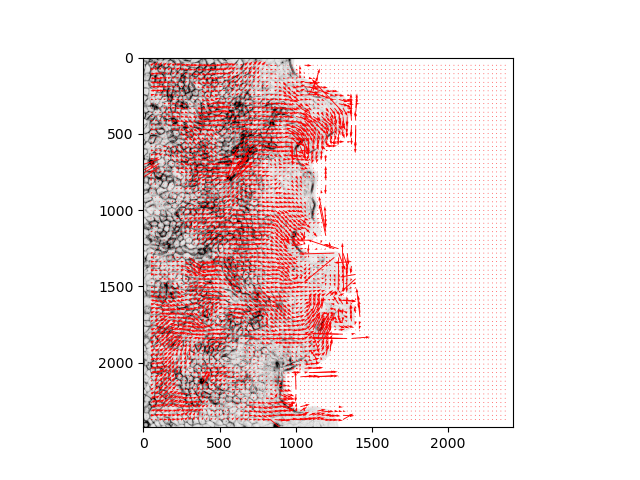

In [8]:
# plot the vector field
plt.figure()
plt.imshow(frame_1, cmap='Greys')
plt.quiver(x,y,u0,-v0, color='r')
plt.show()

In [9]:
# determine which vectors are in the mask
in_mask_flag = [True if mask[int(ypt), int(xpt)] else False for (xpt,ypt) in zip(x.flatten(),y.flatten())]

# reshape the list into the same size as our other arrays
in_mask_flag = np.reshape(in_mask_flag, x.shape)


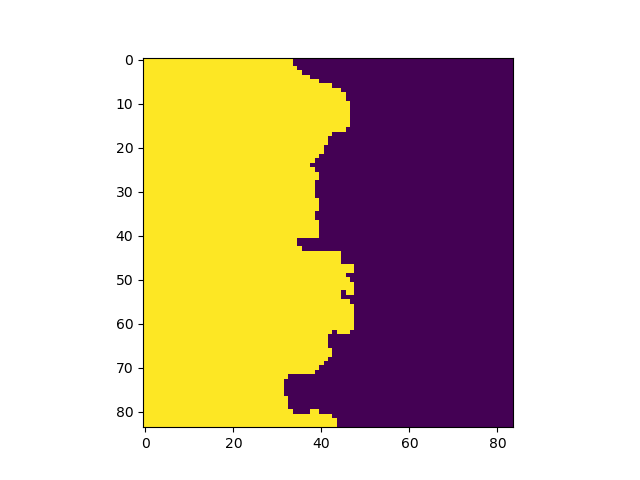

In [10]:
# plot the mask
plt.figure()
plt.imshow(in_mask_flag)
plt.show()

In [11]:
# filter the vector field

# Calculate the flow magnitude for each point
flow_mag = np.sqrt(u0**2 + v0**2)

# find those values more than that threshold
magnitude_flags = flow_mag > flow_mag_threshold

# find those values less than that threshold
sig2noise_flags = sig2noise < sig2noise_threshold

# make mask of vectors to filter
filter_flags = (magnitude_flags + sig2noise_flags) * in_mask_flag
# set those vectors to np.nan
u_orig = u0.copy()
v_orig = v0.copy()
u0[filter_flags] = np.nan
v0[filter_flags] = np.nan

# replace the filtered vectors
u_filtered, v_filtered = filters.replace_outliers(u0, v0,
                                   method='localmean',
                                   max_iter=3,
                                   kernel_size=3)

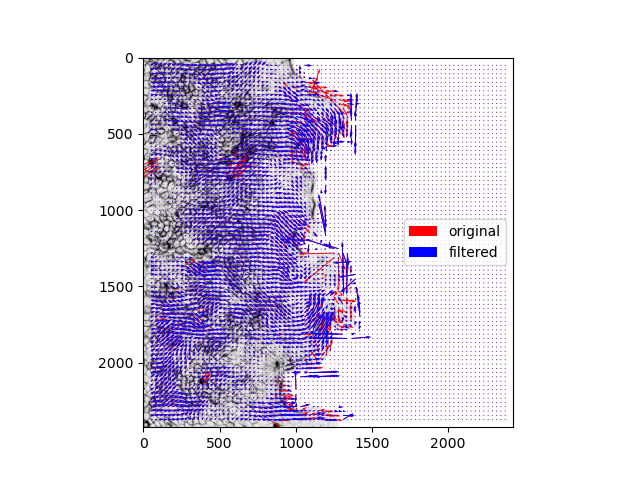

In [12]:
# plot the filtered field
plt.figure()
plt.imshow(frame_1, cmap='Greys')
plt.quiver(x,y,u_orig,-v_orig, color='r', label='original')
plt.quiver(x,y,u_filtered,-v_filtered, color='b', label='filtered')
plt.legend()
plt.show()

In [13]:
# calculate the basic parameters

# convert u,v (cartesian) flow maps to r,theta (polar)
r = np.sqrt(u_filtered**2 + v_filtered**2)
theta = np.arctan2(u_filtered,v_filtered)

# calculate the mean and std of the velocity vectors
speed_mean = np.mean(r[in_mask_flag])
speed_std = np.std(r[in_mask_flag])

# calculate the cosine of the displacement vectors with a vector point to the right (the direction of the migration into the wound)
cos_maps = u_filtered / np.sqrt(u_filtered**2 + v_filtered**2) #this is just from the definition of the dot product of the vectors a = (u,v) and b = (1,0)
# set any nan (from dividing by zero) to 0
cos_maps = np.nan_to_num(cos_maps)

# calculate the mean and std cosine for each image
cos_mean_list = np.nanmean(cos_maps)
cos_std_list = np.nanstd(cos_maps)



/var/folders/qh/qtnhpk3n0wz437fnzt3vhrw00000gp/T/ipykernel_19047/3269438083.py:12: RuntimeWarning: invalid value encountered in divide
  cos_maps = u_filtered / np.sqrt(u_filtered**2 + v_filtered**2) #this is just from the definition of the dot product of the vectors a = (u,v) and b = (1,0)


In [14]:
# do the correlations

# create a distance map centered on an array the size of the flow maps for the correlation calculation
dist_map = np.ones((flow_nrows, flow_ncols))
dist_map[int(flow_nrows / 2),int(flow_ncols / 2)] = 0
dist_map = distance_transform_edt(dist_map)

# create a list of radii to average over
bins = np.arange(0,int(flow_nrows / 2))

# calculate the correlations
r_corr = signal.correlate(r * in_mask_flag, r * in_mask_flag, mode = 'same', method = 'fft')
theta_corr = signal.correlate(theta * in_mask_flag, theta * in_mask_flag, mode = 'same', method = 'fft')

r_radial_average = [np.mean(r_corr[(dist_map > val) & (dist_map <= val+1)]) for val in bins]
theta_radial_average = [np.mean(theta_corr[(dist_map > val) & (dist_map <= val+1)]) for val in bins]
        

In [15]:
# fit the correlations to a single exponential decay
r_R0 = fit_decay_curve(bins, r_radial_average)
theta_R0 = fit_decay_curve(bins, theta_radial_average)
    

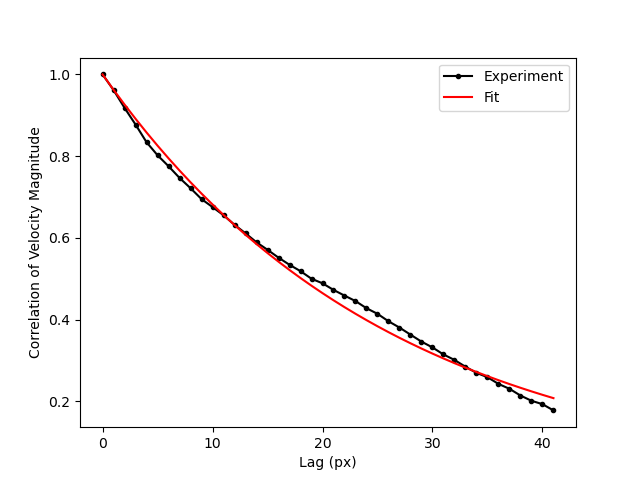

In [16]:
plt.figure()
plt.plot(bins, r_radial_average / r_radial_average[0], '.-k', label='Experiment')
plt.plot(bins, decay_curve(bins, r_R0), '-r', label='Fit')
plt.ylabel('Correlation of Velocity Magnitude')
plt.xlabel('Lag (px)')
plt.legend()
plt.show()

# Looping over many files

## Calculate Flow Fields

In [ ]:
# loop through all the files
for (im, mask) in zip(data_files[2:], mask_files[2:]):
    
    # read in the image and mask
    imstack = io.imread(im)
    imstack_mask = io.imread(mask).astype('bool')
    # make the filename
    filename = im[3:-4] + '.npz'

    # preallocate all the arrays to hold data
    u = np.zeros((n_frames, flow_nrows, flow_ncols))
    v = np.zeros((n_frames, flow_nrows, flow_ncols))
    flow_masks = np.zeros((n_frames, flow_nrows, flow_ncols))
    
    # loop through the frames to calculate the displacement
    for frame_number, (frame_1, frame_2, mask) in enumerate(zip(imstack[:-1],imstack[1:], imstack_mask[1:])):
        # perform the PIV
        try:
            u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_1.astype(np.int32),
                                                               frame_2.astype(np.int32),
                                                               window_size = window_size, overlap = overlap,
                                                               search_area_size = search_size,
                                                               sig2noise_method = 'peak2peak', use_vectorized=True)
        except ValueError: # for in the vectorized version fails
            u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_1.astype(np.int32),
                                                               frame_2.astype(np.int32),
                                                               window_size = window_size, overlap = overlap,
                                                               search_area_size = search_size,
                                                               sig2noise_method = 'peak2peak', use_vectorized=False)
    
        # fill in any nan values
        u0 = np.nan_to_num(u0)
        v0 = np.nan_to_num(v0)
        
        # make the mask for each flow image
        in_mask_flag = [True if mask[int(ypt), int(xpt)] else False for (xpt,ypt) in zip(x.flatten(),y.flatten())]
    
        # reshape the list into the same size as our other arrays
        in_mask_flag = np.reshape(in_mask_flag, x.shape)
        # store the mask
        flow_masks[frame_number] = in_mask_flag
    
        # Calculate the flow magnitude for each point
        flow_mag = np.sqrt(u0**2 + v0**2)
        
        # find those values more than that threshold
        magnitude_flags = flow_mag > flow_mag_threshold
    
        # find those values less than that threshold
        sig2noise_flags = sig2noise < sig2noise_threshold
    
        # make mask of vectors to filter
        filter_flags = (magnitude_flags + sig2noise_flags) * in_mask_flag
        u0[filter_flags] = np.nan
        v0[filter_flags] = np.nan
    
        # replace the filtered vectors
        u_filtered, v_filtered = filters.replace_outliers(u0, v0,
                                           method='localmean',
                                           max_iter=3,
                                           kernel_size=3)
    
        # store the filtered vector fields
        u[frame_number] = u_filtered * in_mask_flag
        v[frame_number] = v_filtered * in_mask_flag
    
        # print the frame number to keep track of progress
        print(f'frame {frame_number} finished')
    
    np.savez(filename, u=u, v=v, x=x, y=y,
             flow_masks=flow_masks, parameters = parameters)


## Analyze the Flow Fields

In [ ]:
# get a list of all the .npz files 
data_npz_list = sorted(glob.glob('*.npz'))

for filename in data_npz_list:
    # load the data file
    flowdata = np.load(filename, allow_pickle=True)
    
    u = flowdata['u']
    v = flowdata['v']
    x = flowdata['x']
    y = flowdata['y']
    flow_masks = flowdata['flow_masks'].astype('bool')
    parameters = flowdata['parameters']

    # convert u,v (cartesian) flow maps to r,theta (polar)
    r = np.sqrt(u**2 + v**2)
    theta = np.arctan2(u,v)

    # store the magnitude of the displacement vectors (this is all in pixels/frame for now)
    velocity_maps = r.copy()
    # calculate the mean and std of the velocity vectors
    speed_mean_list = [np.mean(frame[mask]) for (frame, mask) in zip(r, flow_masks)]
    speed_std_list = [np.std(frame[mask]) for (frame, mask) in zip(r, flow_masks)]

    # calculate the cosine of the displacement vectors with a vector point to the right (the direction of the migration into the wound)
    cos_maps = u / np.sqrt(u**2 + v**2) #this is just from the definition of the dot product of the vectors a = (u,v) and b = (1,0)
    cos_maps = np.nan_to_num(cos_maps)
    # calculate the mean and std cosine for each image
    cos_mean_list = [np.nanmean(frame[mask]) for (frame, mask) in zip(cos_maps, flow_masks)]
    cos_std_list = [np.nanstd(frame[mask]) for (frame, mask) in zip(cos_maps, flow_masks)]

    # create a distance map centered on an array the size of the flow maps for the correlation calculation
    dist_map = np.ones((flow_nrows, flow_ncols))
    dist_map[int(flow_nrows / 2),int(flow_ncols / 2)] = 0
    dist_map = distance_transform_edt(dist_map)

    # create a list of radii to average over
    bins = np.arange(0,int(flow_nrows / 2))

    # create empty arrays to store correlations for r and theta
    r_corr = np.zeros((n_frames, flow_nrows, flow_ncols))
    theta_corr = np.zeros((n_frames, flow_nrows, flow_ncols))
    # create empty arrays to store correlations for mean subtracted versions of r and theta
    r_mean_subtracted_corr = np.zeros((n_frames, flow_nrows, flow_ncols))
    theta_mean_subtracted_corr = np.zeros((n_frames, flow_nrows, flow_ncols))

    # create empty arrays to hold the radially averaged correlations
    r_radial_average = np.zeros((n_frames, int(flow_nrows / 2)))
    theta_radial_average = np.zeros((n_frames, int(flow_nrows / 2)))
    r_mean_subtracted_radial_average = np.zeros((n_frames, int(flow_nrows / 2)))
    theta_mean_subtracted_radial_average = np.zeros((n_frames, int(flow_nrows / 2)))
    
    # loop through each frame
    for frame_number, (r_field, theta_field, mask) in enumerate(zip(r, cos_maps, flow_masks)):
        # calculate the autocorrelation using FFTs
        r_corr[frame_number] = signal.correlate(r_field * mask, r_field * mask, mode = 'same', method = 'fft')
        theta_corr[frame_number] = signal.correlate(theta_field * mask, theta_field * mask, mode = 'same', method = 'fft')

        # calculate the mean subtracted fields
        r_mean_subtracted_field = (r_field - np.mean(r_field[mask])) * mask
        theta_mean_subtracted_field = (theta_field - np.mean(theta_field[mask])) * mask
        # calculate the correlations of the mean subtracted fields
        r_mean_subtracted_corr[frame_number] = signal.correlate(r_mean_subtracted_field, r_mean_subtracted_field, mode = 'same', method = 'fft')
        theta_mean_subtracted_corr[frame_number] = signal.correlate(theta_mean_subtracted_field, theta_mean_subtracted_field, mode = 'same', method = 'fft')
    
        # radially average the correlation fields
        r_radial_average[frame_number] = [np.mean(r_corr[frame_number][(dist_map > val) & (dist_map <= val+1)]) for val in bins]
        theta_radial_average[frame_number] = [np.mean(theta_corr[frame_number][(dist_map > val) & (dist_map <= val+1)]) for val in bins]
        r_mean_subtracted_radial_average[frame_number] = [np.mean(r_mean_subtracted_corr[frame_number][(dist_map > val) & (dist_map <= val+1)]) for val in bins]
        theta_mean_subtracted_radial_average[frame_number] = [np.mean(theta_mean_subtracted_corr[frame_number][(dist_map > val) & (dist_map <= val+1)]) for val in bins]
    
    # calculate the decay cruves by fitting an exponential decay with a single parameter (R0) for each radial average
    r_R0 = [fit_decay_curve(bins, corr) for corr in r_radial_average]
    r_mean_subtracted_R0 = [fit_decay_curve(bins, corr) for corr in r_mean_subtracted_radial_average]
    theta_R0 = [fit_decay_curve(bins, corr) for corr in theta_radial_average]
    theta_mean_subtracted_R0 = [fit_decay_curve(bins, corr) for corr in theta_mean_subtracted_radial_average]

    # save all the data to an npz file
    np.savez(filename, u=u, v=v, x=x, y=y, flow_masks=flow_masks, parameters = parameters,
             velocity_maps = velocity_maps, cos_maps=cos_maps, theta_maps = theta,
             speed_mean_list=speed_mean_list, speed_std_list = speed_std_list,
             cos_mean_list = cos_mean_list, cos_std_list = cos_std_list, 
             r_corr = r_corr, theta_corr = theta_corr, 
             r_mean_subtracted_corr = r_mean_subtracted_corr, theta_mean_subtracted_corr = theta_mean_subtracted_corr,
             r_radial_average = r_radial_average, theta_radial_average = theta_radial_average,
             r_mean_subtracted_radial_average = r_mean_subtracted_radial_average, theta_mean_subtracted_radial_average = theta_mean_subtracted_radial_average,
             r_R0 = r_R0, r_mean_subtracted_R0 = r_mean_subtracted_R0, theta_R0 = theta_R0, theta_mean_subtracted_R0 = theta_mean_subtracted_R0
            )
